# PRELIMINARIES

In [1]:
# !pip freeze > requirements.txt

In [2]:
import sys
import os

is_colab = 'google.colab' in sys.modules

if is_colab==True:
    from google.colab import files, output, drive
    drive.mount('/gdrive')
    %cd /gdrive
    print("You're on Google Colab")
else:
    print("You're on a PC")

if is_colab==True:
    if os.getcwd()!='/gdrive/My Drive/--DATA SCIENCE/PROJET4':
        os.chdir('My Drive/--DATA SCIENCE/PROJET4')
    !pip install -r requirements_modelling.txt
else:
    # make sure 'P4_functions.py' is in the current working directory
    file_required('/P4_functions.py')
    file_required('requirements_modelling.txt')
    !pip install -r requirements_modelling.txt

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive
You're on Google Colab
     |████████████████████████████████| 81kB 2.1MB/s 
  Created wheel for gTTS-token: filename=gTTS_token-1.1.3-cp36-none-any.whl size=4097 sha256=75cc6d8c7fea39ad7d4fe62d25c67d72391d5b00863113f0fce6e64840f5b357
  Stored in directory: /root/.cache/pip/wheels/dd/11/61/33f7e51bf545e910552b2255eead2a7cd8ef54064b46dceb34
Successfully built gTTS-token


In [4]:
from P4_functions import *
import io
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor']='w'
import warnings
warnings.filterwarnings('ignore')
# from ipywidgets import interact, interact_manual
import dill
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from mlxtend.plotting import plot_pca_correlation_graph
from sklearn.inspection import permutation_importance
import category_encoders as ce
import scipy.stats as st
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import * 
from sklearn.linear_model import *
from sklearn import metrics
from sklearn.compose import make_column_transformer

dictPdSettings = {'display.max_rows': 500, 'display.width': 100,
                    'display.max_colwidth': 500,
                    'display.float_format': lambda x: '%.2f' % x}
for k,v in dictPdSettings.items():
    pd.set_option(k,v)

In [5]:
if is_colab==True:
    path_csv = 'DATA/Cleaned_data.csv' 
    # Importing database from my Drive
    print("2. Try to import in notebook from myDrive...")
else:
    path_csv = '../DATA/Cleaned_data.csv'
    # Importing database from a DATA directory
    print("2. Try to import in notebook from PC ('DATA')")

df_orig = pd.read_csv(path_csv, sep=',', index_col='Unnamed: 0',
                 low_memory=True, encoding ='utf-8')

print("-----> importation of .csv in the notebook OK")

df_orig['ZipCode'] = df_orig['ZipCode'].apply(str).astype('object')
df_orig['CouncilDistrictCode'] = df_orig['CouncilDistrictCode'].apply(str).astype('object')

2. Try to import in notebook from myDrive...
-----> importation of .csv in the notebook OK


In [6]:
df_orig.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType', 'PropertyName',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood', 'YearBuilt',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified', 'ENERGYSTARScore',
       'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'OtherFuelUse(kBtu)',
       'TotalGHGEmissions', 'GHGEmissionsIntensity', 'DefaultData', 'Comments', 'ComplianceStatus',
       'Outlier', 'ZipCode', 'La

Selection of columns and creation of training and testing sets

In [7]:
prop_Q_cols = ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
               'PropertyGFAParking', 'PropertyGFABuilding(s)',
               'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
               'ThirdLargestPropertyUseTypeGFA', 'BuildingAge',
               'MeanGFAperFloor', 'ParkingGFARatio', 'NbYearsCertified',
               'ExtsurfVolRatio', 'Outlier'] # 'ENERGYSTARScore',

prop_C_cols = ['Neighborhood', 'ZipCode', 'CouncilDistrictCode',
               'BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType',
               'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
               'CertifiedPreviousYear', 'EnergyProfile', 'MainEnergy']

target_cols = ['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions',
                'SiteEnergyUseWN(kBtu)_log', 'TotalGHGEmissions_log']

In [8]:
df = df_orig[prop_Q_cols+prop_C_cols+target_cols]

group_col = 'PrimaryPropertyType' # for stratification
df_tr, df_te = train_test_split(df, train_size=0.8, shuffle=True,
                                     stratify=df[group_col], random_state=14)

X_tr, X_te = df_tr[prop_Q_cols+prop_C_cols], df_te[prop_Q_cols+prop_C_cols]
y_tr, y_te = df_tr['SiteEnergyUseWN(kBtu)'], df_te['SiteEnergyUseWN(kBtu)']

y_log_tr, y_log_te  = np.log(y_tr), np.log(y_te)

In [9]:
X_tr.shape, y_tr.shape

((1320, 25), (1320,))

In [10]:
X_te.shape, y_te.shape

((331, 25), (331,))

## Models

Creating dataframes for comparison of the models

In [ ]:
df_res = pd.DataFrame(dtype = 'object')

In [ ]:
df_feat_imp = pd.DataFrame(dtype = 'object')

In [ ]:
dict_models = {}

Creating the stratified Kfold generator for cross-validation

In [ ]:
skf = list(StratifiedKFold(3).split(X_tr,X_tr[group_col]))

## FONCTION

# Default preprocessing

- encoding of categorical data
- standardisation

Feature selection based on the variance of the data

In [ ]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
X_tr_Q = X_tr.select_dtypes(include=(np.number))
for c in X_tr_Q.columns :
    print(f"{c:-<40}{np.var(X_tr_Q.loc[:,c])}")

## MODELS

In [ ]:
cv_scoring =  ['mae','rmse','r2','pred_rate_10']
refit_scoring = 'pred_rate_10'

In [ ]:
X_tr.shape

In [ ]:
log1p_on = False

if log1p_on: # scores defined in P4_functions.py
    y_mod_tr, y_mod_te = np.log1p(y_tr), np.log1p(y_te)
    scorers = {'mae_log': mae_log,
               'rmse_log': mae_log,
               'r2_log': r2_log,
               'pred_rate_10_log': pred_rate_10_log}
    score_refit = 'pred_rate_10_log'
    file_name = os.getcwd()+'/P4_models_log_SEU.pkl'
else:
    y_mod_tr, y_mod_te = y_tr, y_te
    scorers = {'mae': mae,
               'rmse': mae,
               'r2': r2,
               'pred_rate_10': pred_rate_10}
    score_refit = 'pred_rate_10'

## KNN Regressor

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression

reg = KNeighborsRegressor()
name_reg = 'KNN_grid'
param_grid={'preproc__cust_trans__strat_binary': ['ord'],
            'preproc__cust_trans__strat_low_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_high_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_quant': ['stand'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            'feat_sel__k_best__k': range(10,25),
            'feat_sel__k_best__score_func': [f_regression, mutual_info_regression], #,mutual_info_regression
            name_reg+'__n_neighbors': [5], # 1,2,3,5,7,9,11,15,17
            name_reg+'__p': [1]} # 1,2

feat_sel_pipe = Pipeline([('k_best', SelectKBest())])
preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
pipe = Pipeline([('preproc', preproc_pipe),
	    	     ('feat_sel', feat_sel_pipe),
	             (name_reg, reg)])
# pipe.get_params().keys() # to display available parameters

dict_models[name_reg] = \
    model_optimizer(name_reg, reg, param_grid,
                    pipe, X_tr, y_tr,
                    cv_search = skf,
                    scv_scores = scorers,
                    refit = score_refit,
                    search_strat = 'grid',
                    verbose=2, n_iter=50)

new_df_res = scv_perf_fetcher(name_reg, dict_models[name_reg])
df_res = pd.concat([df_res, new_df_res], axis=1)

Grid
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  5.1min finished


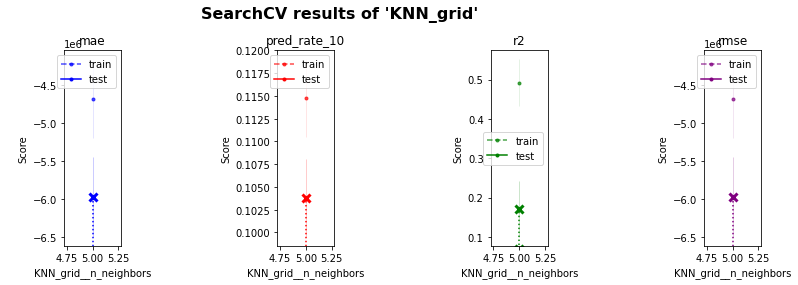

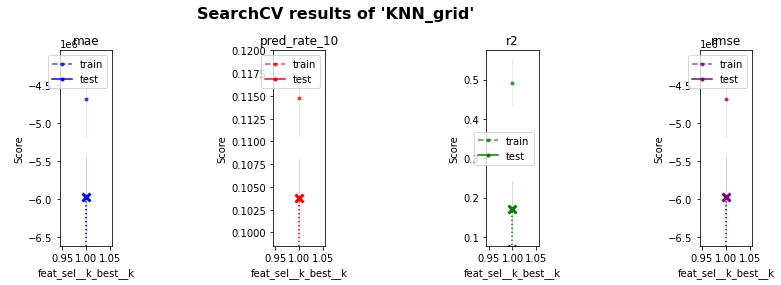

In [ ]:
name_reg='KNN_grid'
scv = dict_models[name_reg]
param = name_reg+'__'+'n_neighbors'
plot_scv_multi_scores(name_reg, scv, param, )
param = 'feat_sel__k_best__k'
plot_scv_multi_scores(name_reg, scv, param)

Plotting the score for two parameters

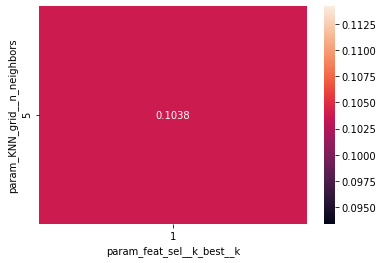

In [ ]:
name_reg='KNN_grid'
scv = dict_models[name_reg]
params = ['KNN_grid__n_neighbors', 'feat_sel__k_best__k']
plot_2D_hyperparam_opt(scv=scv, params=params, score=score_refit)



Learning curve

ValueError: ignored

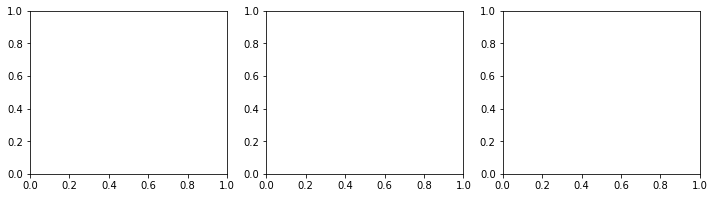

In [ ]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
colors = sns.color_palette("dark", 10)

### Changer la taille des marqueurs et le remplissage pour test et fixer la l

fig, axes = plt.subplots(1, 3, figsize=(12, 3));
for name_reg, c in zip(dict_models.keys(), colors):
    # title = f"Learning Curves ({name_reg})"
    model = dict_models[name_reg].best_estimator_
    plot_learning_curve(model, X_tr, y_mod_tr, #ylim=(0.7, 1.01),
                        cv=cv, scoring = rev_log1p_r2,#n_jobs=4,
                        train_sizes = np.linspace(0.1,1,20),
                        c=c, axes=axes)
plt.show()

Getting the permutation feature importance for regression

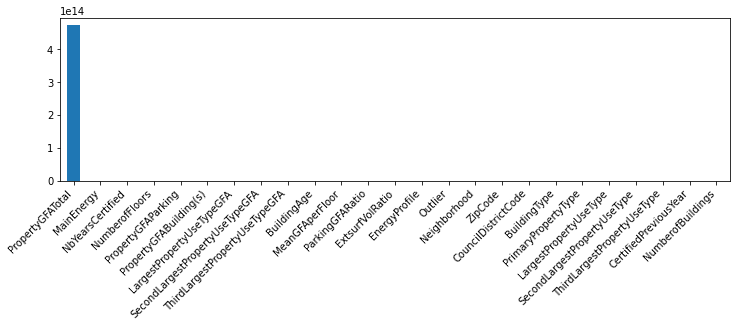

In [ ]:
from sklearn.inspection import permutation_importance

scv = dict_models[name_reg]
results = permutation_importance(scv, X_tr, y_tr, scoring='neg_mean_squared_error')
importance = results.importances_mean

fig, ax = plt.subplots()
df_ = pd.DataFrame(importance, index = X_tr.columns, columns=[name_reg])
df_[name_reg].sort_values(ascending=False).plot.bar()
fig.set_size_inches(12,3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right" )
plt.show()

In [ ]:
df_feat_imp = pd.concat([df_feat_imp,df_], axis=1)
df_feat_imp.rank().iloc[:,1].sort_values().index

IndexError: ignored

In [ ]:
df_feat_imp.rank()

,KNN_grid,KNN_grid
NumberofBuildings,10.00,21.00
NumberofFloors,25.00,19.00
PropertyGFATotal,3.00,22.00
PropertyGFAParking,1.00,20.00
PropertyGFABuilding(s),20.00,23.00
LargestPropertyUseTypeGFA,24.00,24.00
SecondLargestPropertyUseTypeGFA,11.00,2.00
ThirdLargestPropertyUseTypeGFA,22.00,25.00
BuildingAge,21.00,16.00
MeanGFAperFloor,2.00,14.00


## Ridge regression

In [ ]:
df_res

In [ ]:
from sklearn.linear_model import Ridge

reg = Ridge()
name_reg = 'Ridge_rand'
param_grid={'preproc__strat_binary': ['ord'],
            'preproc__strat_low_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__strat_high_card': ['bin'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__strat_quant': ['stand'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            name_reg+'__alpha': st.loguniform(1e-7, 1e7)}
            # name_reg+'__alpha': np.logspace(-7,7,20)}

dict_models[name_reg] = \
        model_optimizer(CustTransformer(thresh_card=12),
                        name_reg, reg, param_grid,
                        X_tr, y1_tr,
                        cv_search=skf, # default : refit='neg_root_mean_squared_error'
                        scv_scores = ['neg_root_mean_squared_error', 
                                      'neg_mean_absolute_error',
                                      'r2'],
                        search_strat='rand', n_iter=10)

new_df_res = scv_perf_fetcher(name_reg, dict_models[name_reg])
df_res = pd.concat([df_res, new_df_res], axis=1)

In [ ]:
name_reg='Ridge_rand'
scv = dict_models[name_reg]
param = name_reg+'__'+'alpha'
plot_scv_multi_scores(name_reg, scv, param)

## Linear regression (no regularization)

In [ ]:
df_lr = pd.DataFrame(dtype = 'object')

#### 'SiteEnergyUse(kBtu)' target

With all the features

In [ ]:
reg = LinearRegression()
name_reg = 'LinReg(all)'

# pipe = make_pipeline(CustTransformer(thresh_card=12), reg)
pipe = Pipeline([("cust_trans", CustTransformer(thresh_card=12)), 
                 (name_reg, reg)])
pipe.fit(X_tr,y1_tr)

df_lr = get_append_scores(name_reg, pipe, X_te, y1_te, df_lr, cv=5)

In [ ]:
pipe.named_steps[name_reg].coef_
# sgd_randomized_pipe.best_estimator_.named_steps['clf']

With selection of the features, trying to avoid colinearity

In [ ]:
reg = LinearRegression()
name_reg = 'LinReg(sel)'

pipe = make_pipeline(CustTransformer(thresh_card=12), reg)
pipe.fit(X_tr_sel,y1_tr)

df_lr = get_append_scores(name_reg, pipe, X_te_sel, y1_te, df_lr, cv=5)

#### 'SiteEnergyUse(kBtu)_log' target

In [ ]:
reg = LinearRegression()
name_reg = 'LinReg_log(all)'

pipe = make_pipeline(CustTransformer(thresh_card=12), reg)
pipe.fit(X_tr,y1_log_tr)

y_pr = pipe.predict(X_te)

df_lr = get_append_scores(name_reg, pipe, X_te, y1_log_te, df_lr, cv=5)

Show all the results

In [ ]:
df_lr

## All Linear Regressions

In [ ]:
'''MODELES REGRESSEURS LINEAIRES DANS SKLEARN : 
Lars, LassoLars, ARDRegression, BayesianRidge, SGDRegressor, HuberRegressor,
RANSACRegressor, TheilSenRegressor, TweedieRegressor, GammaRegressor,
PoissonRegressor, PassiveAggressiveRegressor'''

from sklearn.linear_model import *

In [ ]:
# sans optimisation

df_non_opt = pd.DataFrame(dtype = 'object')

for name_reg, reg in zip(['Ridge', 'Lasso', 'ElasticNet', 'Lars', 'LassoLars',
                          'ARDRegression', 'BayesianRidge', 'SGDRegressor',
                          'HuberRegressor', 'RANSACRegressor', 'TheilSenRegressor',
                          'PassiveAggressiveRegressor',
                          'PoissonRegressor', 'TweedieRegressor', 'GammaRegressor'],
                         [Ridge(), Lasso(), ElasticNet(), Lars(), LassoLars(),
                          ARDRegression(), BayesianRidge(), SGDRegressor(),
                          HuberRegressor(), RANSACRegressor(), TheilSenRegressor(),
                          PassiveAggressiveRegressor(),
                          PoissonRegressor(), TweedieRegressor(), GammaRegressor()]):

    pipe = make_pipeline(CustTransformer(thresh_card=12), reg)
    pipe.fit(X_tr,y1_tr)

    df_non_opt = get_append_scores(name_reg, pipe, X_te, y1_te, df_non_opt, cv=6)
df_non_opt


In [ ]:
# import dill
# file = open(os.getcwd()+'/P4_dict_gscv.pkl', 'wb')
# dill.dump(dict_gscv, file)

In [ ]:
# file = open(os.getcwd()+'/P4_dict_gscv.pkl', 'rb')
# dict_gscv = dill.load(file)

# COUCOU

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA()

Plotting the predicted values against the true values in test set for different groups.

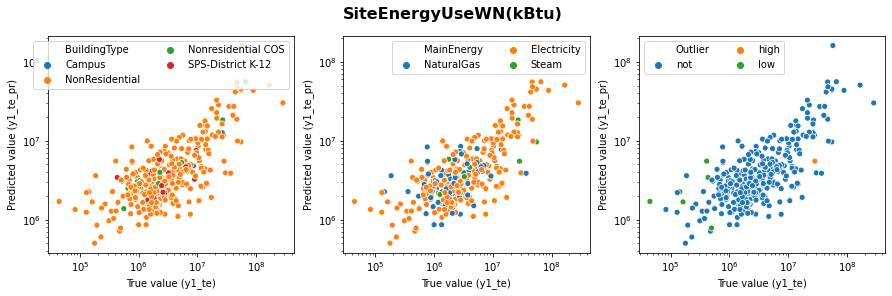

In [ ]:
name_reg='KNN_grid'
scv = dict_models[name_reg]

y1_pr = scv.predict(X_te)

col_groups = ['BuildingType', 'MainEnergy', 'Outlier']
fig, axs = plt.subplots(1,len(col_groups))
for c, ax in zip(col_groups, axs):
    sns.scatterplot(y1_te, y1_pr, hue=X_te[c], ax=ax)
    ax.set_xscale('log'), ax.set_yscale('log'),
    ax.set_xlabel('True value (y1_te)')
    ax.set_ylabel('Predicted value (y1_te_pr)')
    ax.legend( ncol=2, )#bbox_to_anchor=(0.6,-0.2),
fig.suptitle('SiteEnergyUseWN(kBtu)', fontsize=16, fontweight='bold')
fig.set_size_inches(5*len(col_groups),4)
fig.set_facecolor('w')
plt.show()

In [ ]:
# model = enet_gscv.best_estimator_
# # label = "enet_regressor"
# model = dict_models['ElasticNet_rand'].best_estimator_
# label = "ElasticNet_rand"
# fig = None
# %matplotlib
# fig = plot_learning_curve(model, X_tr, y1_tr,
#                           train_sizes=np.linspace(0.1,1,10),
#                           scoring="neg_mean_squared_error", label=label,
#                           c='r', fig = fig)
# %matplotlib inline
# fig

In [ ]:
### OLD VERSION OF THE CELL OPTIMIZING ONE MODEL, replaced by run_optimization

from sklearn.neighbors import KNeighborsRegressor

reg = KNeighborsRegressor()
name_reg = 'KNN_grid'
param_grid={'preproc__strat_binary': ['ord'],
            'preproc__strat_low_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__strat_high_card': ['ohe', 'bin'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__strat_quant': ['stand'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            name_reg+'__n_neighbors': [1,2], # 1,2,3,5,7,9,11,15,17
            name_reg+'__p': [1]} # 0,1,2

# If model with the same name already in dict_models, just takes existing model
if dict_models.get(name_reg, np.nan) is not np.nan:
    print('-----Model already exists - taking existing model')
# Else computes new model and add to the dictionnary, and then to the pickle
else:
    print('-----Model not existing - computing...')
    dict_models[name_reg] = \
        model_optimizer(CustTransformer(thresh_card=12),
                        name_reg, reg, param_grid,
                        X_tr, y_mod_tr,
                        cv_search=skf, # default : refit='neg_root_mean_squared_error'
                        scv_scores = scorers,
                        search_strat='grid',
                        refit = score_refit)#, n_iter=20)
    with open(os.getcwd()+'/P4_models.pkl', "wb") as f:
        dill.dump(dict_models, f)
    print("-----...model dumped")

new_df_res = scv_perf_fetcher(name_reg, dict_models[name_reg])
df_res = pd.concat([df_res, new_df_res], axis=1)

In [ ]:
param1 = name_reg+'__'+'n_neighbors'
param2 = name_reg+'__'+'p'
param3 = 'preproc__strat_high_card'
params = [param1, param2]

plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=params,
                       score = score_refit)